This notebook is for evaluating the performance of the trained Deep Koopman Autoencoder.

In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import h5py
import numpy as np
from scipy.spatial.distance import cdist

from magtense.utils import plot_M_thin_film

from koopmag.database import create_db_mp
from koopmag.utils import plot_dynamics, plot_avg
from koopmag.data_utils import train_test_split
from koopmag.koopman_model import DeepKoopman, KoopmanAE

import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from torch.utils.tensorboard import SummaryWriter

from mpl_toolkits.axes_grid1 import make_axes_locatable
def add_colorbar(im, fig, ax) -> None:
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im, cax=cax, orientation='vertical')

In [3]:
datapath = Path().cwd().parent / "data"

try:
    db = h5py.File(datapath / "1000_150_40_16.h5", "r")
    print("Successfully loaded data")

    print("Attributes of database:")
    for key in db.attrs:
        print(f"{key}: {db.attrs[key]}")

    print("\nData in the database:")
    for key in db:
        print(f"{key}: {db[key].shape}")

    # extract external fields
    Hs = np.array(db["field"])

    # extract data
    DATA = np.array(db["sequence"])
    db.close()

except FileNotFoundError:
    print("Database not found. Please try again.")

Successfully loaded data
Attributes of database:
grid_size: [5.e-07 2.e-07 3.e-09]
h_ext_angle: [  0 360]
h_ext_norm: [ 0 50]
res: [40 16  1]
seed: 0
t_per_step: 1.5e-11
t_steps: 150

Data in the database:
field: (1000, 3)
sequence: (1000, 150, 40, 16, 3)


In [4]:
_, test_dataset, train_indices, test_indices = train_test_split(
                                                DATA,
                                                Hs,
                                                dataset_type="full",
                                                test_size=0.2,
                                                seed=1,
                                                )       

In [5]:
batch_size = 12

testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
print(f"max Hs: {np.max(Hs, axis=0)}")
print(f"min Hs: {np.min(Hs, axis=0)}")

max Hs: [49.49945 48.25204  0.     ]
min Hs: [-47.722034 -49.30808    0.      ]


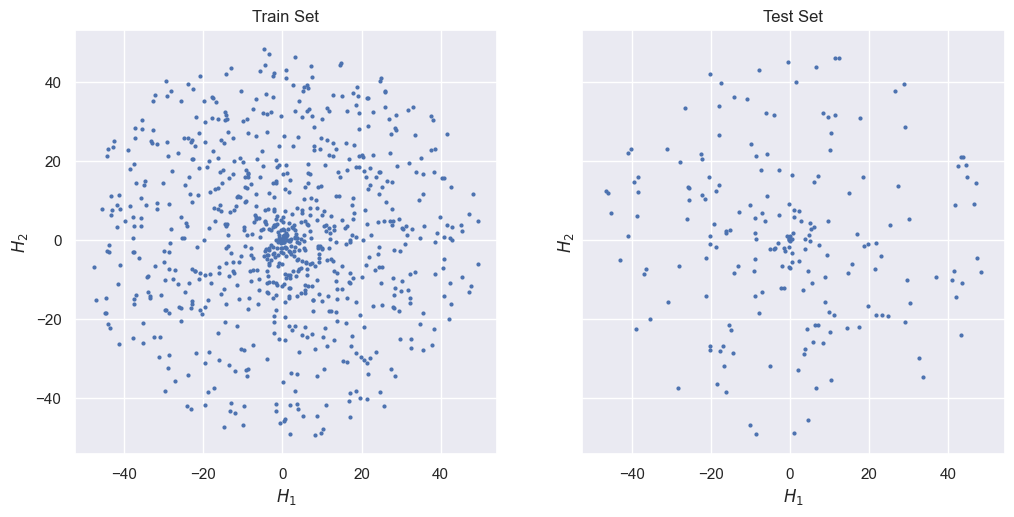

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True, sharex=True)

axs[0].plot(Hs[train_indices][:, 0], Hs[train_indices][:, 1], "o", markersize=2)
axs[0].set(title="Train Set", xlabel="$H_1$", ylabel="$H_2$", aspect="equal") 
axs[1].plot(Hs[test_indices][:, 0], Hs[test_indices][:, 1], "o", markersize=2)
axs[1].set(title="Test Set", xlabel="$H_1$", ylabel="$H_2$", aspect="equal")
plt.show()

## Check how similar the test set is to the training dataset

min dist: 0.03299704680133094, num: 0
max dist: 99.39877612503372
mean dist: 36.8938801541658
std dist: 19.039797607023313


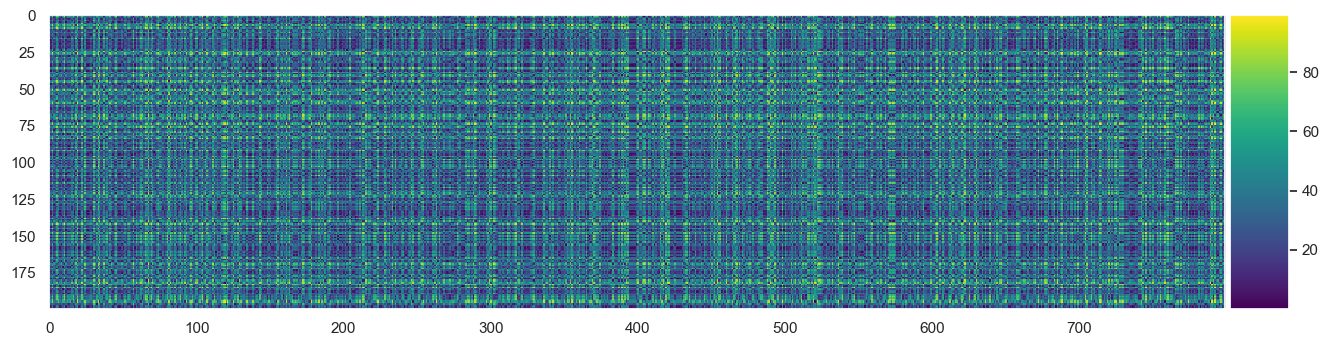

In [8]:
dist_mat = cdist(Hs[test_indices], Hs[train_indices], metric="euclidean")

print(f"min dist: {np.min(dist_mat)}, num: {np.sum(dist_mat == 0)}")
print(f"max dist: {np.max(dist_mat)}")
print(f"mean dist: {np.mean(dist_mat)}")
print(f"std dist: {np.std(dist_mat)}")

fig, ax = plt.subplots(figsize=(16, 12))
im = ax.imshow(
    dist_mat,
    cmap="viridis",
    interpolation="nearest",
    aspect="equal",
)
add_colorbar(im, fig, ax)
ax.grid(False)
plt.show()

## Koopman Autoencoder

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

chns = [256, 128, 64]
latent_dim = 64
act_fn = nn.Tanh

LEARN_A = True

koopman = DeepKoopman(
    chns=chns,
    latent_dim=latent_dim,
    act_fn=act_fn,
    learn_A=LEARN_A,
    method="tikh",
    lam=5.
    ).to(device)

In [10]:
# load model parameters
koopman.load_state_dict(torch.load(datapath / "koopman_full_1000data_100epoch_32batch.pth", weights_only=True))
koopman = koopman.to(device)    

In [11]:
koopman.eval()

Ypreds = []
with torch.no_grad():
    for (xtest, utest) in testloader:
        xtest, utest = xtest.to(device), utest.to(device)
        yhat = koopman.predict(xtest[:, 0, :, :, :], utest)
        Ypreds.append(yhat.detach().cpu().numpy())

Ypreds = np.concatenate(Ypreds, axis=0)

In [12]:
Ypreds.shape

(200, 151, 40, 16, 3)

## Investigate where the model performs badly

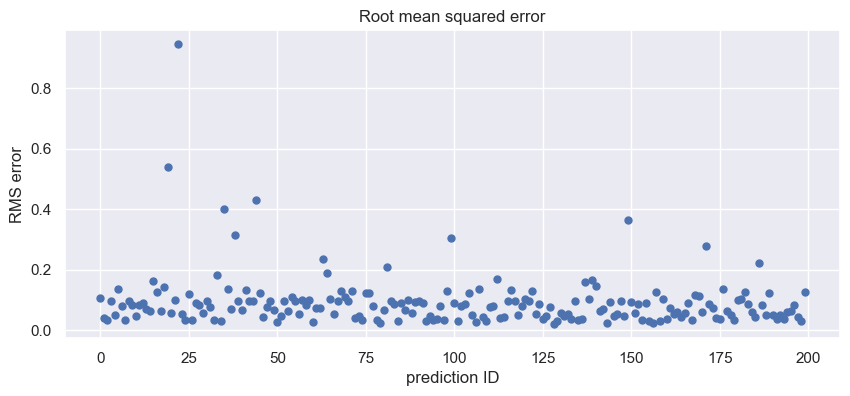

In [52]:
error2 = (DATA[test_indices] - Ypreds[:, :-1, :, :, :]) ** 2
mean_error2 = np.mean(error2, axis=(2, 3))          # mean squared error per pixel

total_mean_error2 = np.mean(mean_error2, axis=2)    # mean squared error across channels (mag componenents)      
total2_mean_error2 = np.mean(total_mean_error2, axis=1)    # mean squared error across time 

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(np.sqrt(total2_mean_error2), "o", markersize=5)
ax.set(title="Root mean squared error", xlabel="prediction ID", ylabel="RMS error")
plt.show()

tensor(558)


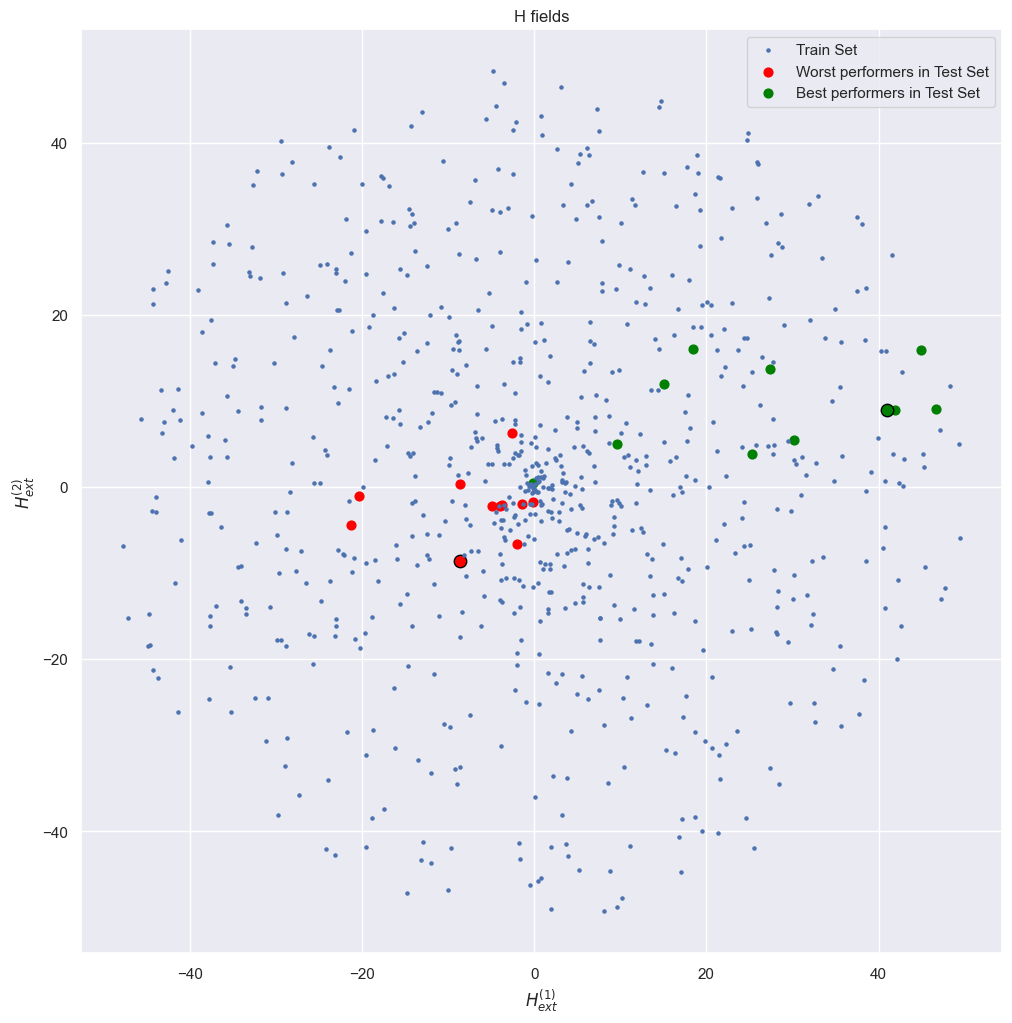

In [88]:
sorted_idx = np.argsort(total2_mean_error2) 
worst_idxs = sorted_idx[-10:]
best_idxs = sorted_idx[:10]

print(test_indices[worst_idxs[-1]])

fig, ax = plt.subplots(figsize=(12, 12))

ax.scatter(Hs[train_indices][:, 0], Hs[train_indices][:, 1], s=5, label="Train Set", zorder=15)
ax.scatter(Hs[test_indices[worst_idxs]][:, 0], Hs[test_indices[worst_idxs]][:, 1],c="red", s=40, label="Worst performers in Test Set")
ax.scatter(Hs[test_indices[best_idxs]][:, 0], Hs[test_indices[best_idxs]][:, 1],c="green", s=40, label="Best performers in Test Set")
ax.scatter(Hs[test_indices[worst_idxs[-1]], 0], Hs[test_indices[worst_idxs[-1]], 0],c="red", s=80, edgecolors="black")
ax.scatter(Hs[test_indices[[1]], 0], Hs[test_indices[best_idxs[1]], 1],c="green", s=80, edgecolors="black")
ax.legend()
ax.set(title="H fields", xlabel="$H_{ext}^{(1)}$", ylabel="$H_{ext}^{(2)}$", aspect="equal")
plt.show()

## Poor prediction examples:

distance of H_worst to closest training point: 1.1399907055702094
mean distance of H_worst to closest training point: 26.79186979245947


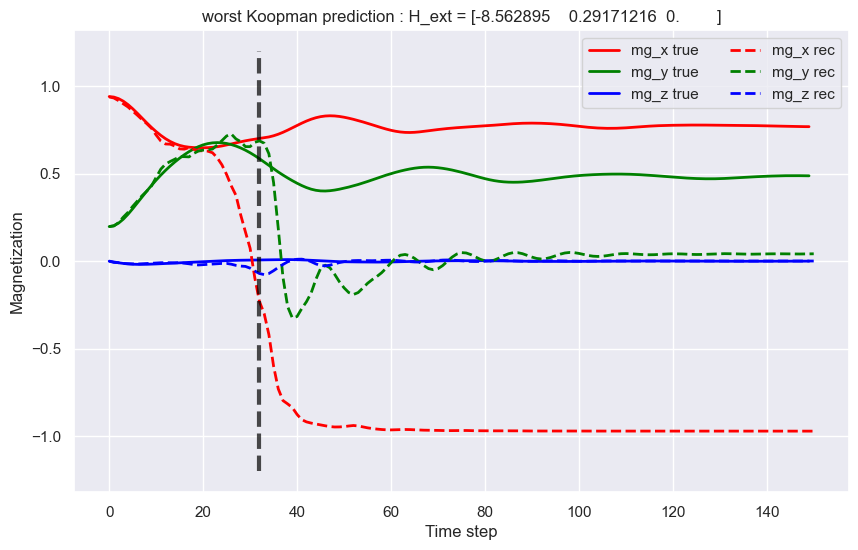

In [85]:
print(f"distance of H_worst to closest training point: {np.min(dist_mat[worst_idxs[-1]])}")
print(f"mean distance of H_worst to closest training point: {np.mean(dist_mat[worst_idxs[-1]])}")

fig, ax = plt.subplots(figsize=(10, 6))

plot_avg(DATA[test_indices[worst_idxs[-1]]], ax, linestyle="-", annot="true")
plot_avg(Ypreds[worst_idxs[-1]], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title=f"worst Koopman prediction : H_ext = {Hs[test_indices[worst_idxs[-1]]]}")
ax.vlines(x=[32], ymin=-1.2, ymax=1.2, color="black", linestyle="--", linewidth=3, alpha=0.7)
plt.show()

## Good prediction example:

distance of H_best to closest training point: 0.7534602194215939
mean distance of H_best to training points: 38.22638070550248


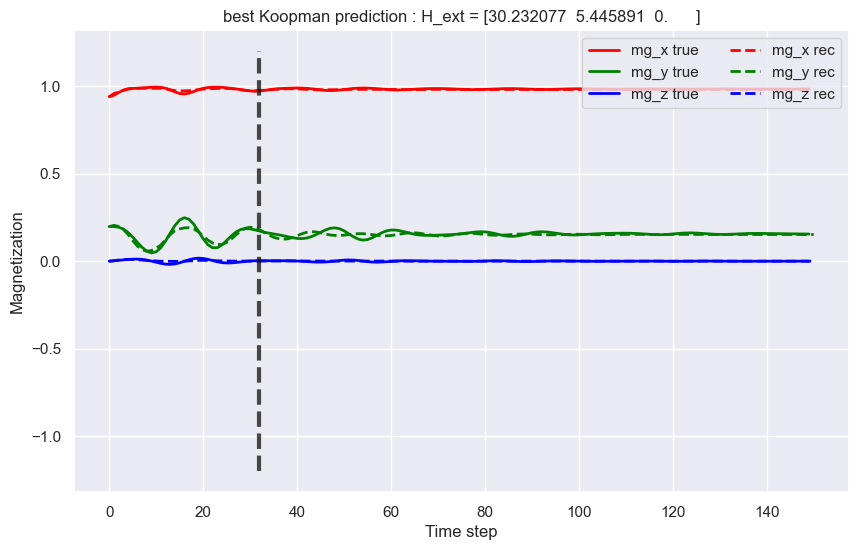

In [86]:
print(f"distance of H_best to closest training point: {np.min(dist_mat[best_idxs[0]])}")
print(f"mean distance of H_best to training points: {np.mean(dist_mat[best_idxs[0]])}")

fig, ax = plt.subplots(figsize=(10, 6))

plot_avg(DATA[test_indices[best_idxs[0]]], ax, linestyle="-", annot="true")
plot_avg(Ypreds[best_idxs[0]], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title=f"best Koopman prediction : H_ext = {Hs[test_indices[best_idxs[0]]]}")
ax.vlines(x=[32], ymin=-1.2, ymax=1.2, color="black", linestyle="--", linewidth=3, alpha=0.7)
plt.show()

distance of H 39 to closest training point: 1.977032499911033
mean distance of H 39 to training points: 47.14895701196918


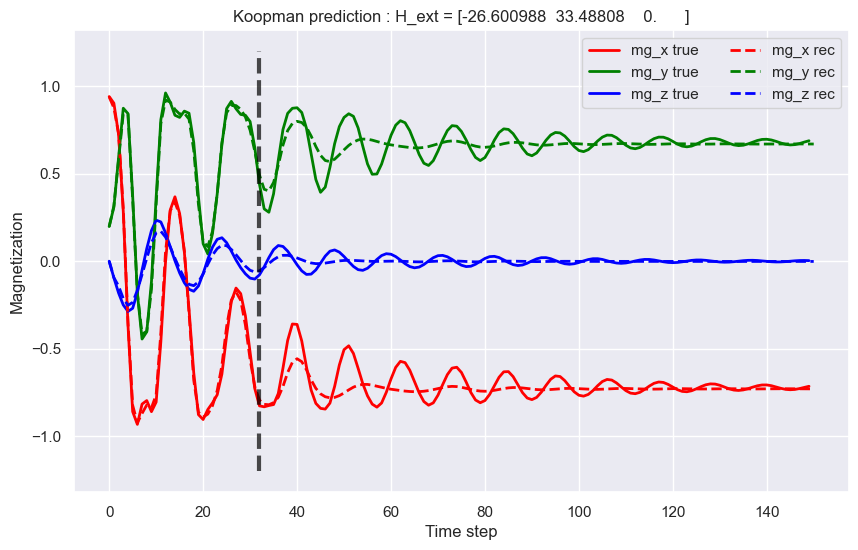

In [87]:
field_idx = 39
print(f"distance of H {field_idx} to closest training point: {np.min(dist_mat[field_idx])}")
print(f"mean distance of H {field_idx} to training points: {np.mean(dist_mat[field_idx])}")
#field_idx = best_idx

fig, ax = plt.subplots(figsize=(10, 6))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Ypreds[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title=f"Koopman prediction : H_ext = {Hs[test_indices[field_idx]]}")
ax.vlines(x=[32], ymin=-1.2, ymax=1.2, color="black", linestyle="--", linewidth=3, alpha=0.7)
plt.show()

In [77]:
koopman.eval()

Xrec = []
with torch.no_grad():
    for (xtest, _) in testloader:
        xtest = xtest.to(device)
        xhat = koopman.autoencoder(xtest)
        Xrec.append(xhat.detach().cpu().numpy())

del xtest
Xrec = np.concatenate(Xrec, axis=0)

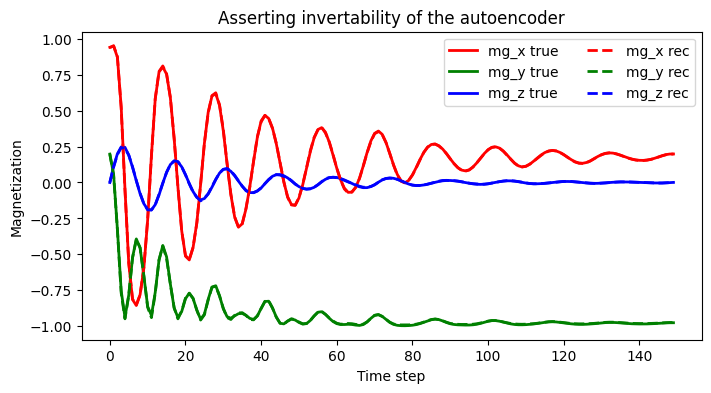

In [78]:
field_idx = 0

fig, ax = plt.subplots(figsize=(8, 4))

plot_avg(DATA[test_indices[field_idx]], ax, linestyle="-", annot="true")
plot_avg(Xrec[field_idx], ax, linestyle="--", annot="rec")
ax.set(xlabel="Time step", ylabel="Magnetization", title="Asserting invertability of the autoencoder")
plt.show()

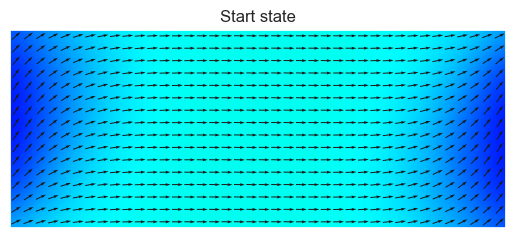

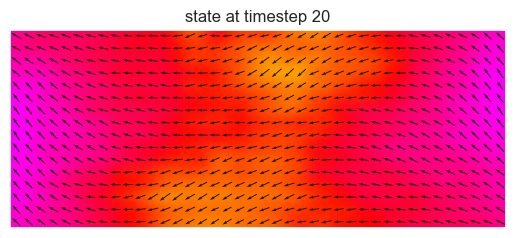

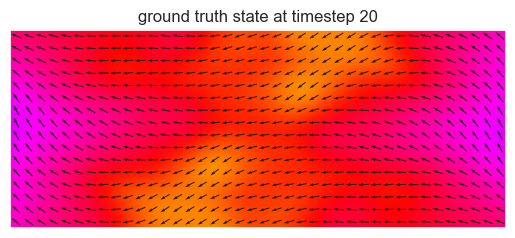

In [95]:
res = np.array([40, 16, 1])
middle_state = 20

plot_M_thin_film(Ypreds[field_idx][0], res, "Start state")
plot_M_thin_film(Ypreds[field_idx][middle_state], res, f"state at timestep {middle_state}")
plot_M_thin_film(DATA[test_indices[field_idx]][middle_state], res, f"ground truth state at timestep {middle_state}")

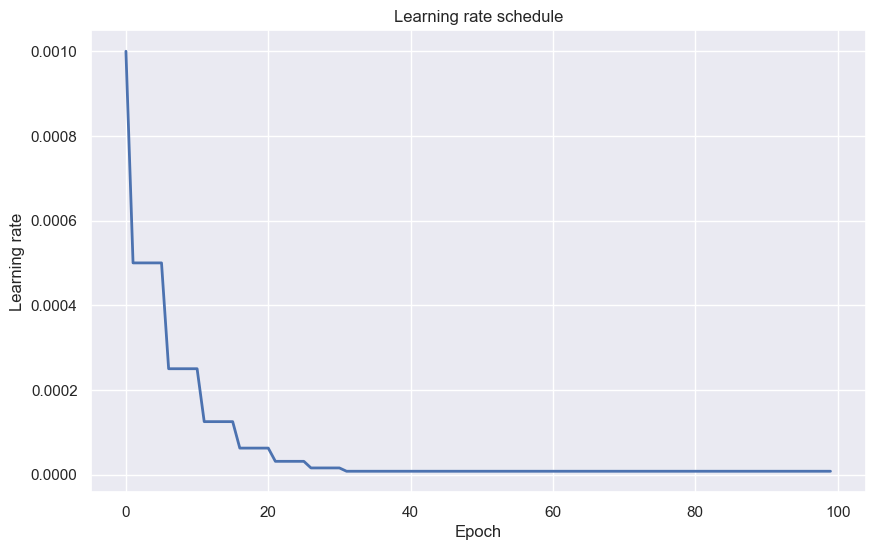

In [96]:
lr = 1e-3
beta = 0.5

num_epochs = 100

step_every = 5
lrs = np.zeros(num_epochs)
for i in range(num_epochs):
    lrs[i] = lr
    if i % step_every == 0 and lr > 1e-5:
        lr *= beta


fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(np.arange(num_epochs), lrs, "-", linewidth=2)
ax.set(title="Learning rate schedule", xlabel="Epoch", ylabel="Learning rate")
#ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
plt.show()